# Note
Previous notebook drafts have analyzed several classification methods not included here, particularly SVM methods. The SVM classifiers did not return quality results and took long times to run. They are therefore not included in this analysis.

# Defining Parameters

* **Data**: Structured
* **Model Imbalance**: ADASYN
* **Grid Search Scoring Parameter**: f1_macro

In [2]:
scoring_metric = 'f1_macro'
max_iter_log = 5000

# Library Calls

In [3]:
import pandas as pd
import numpy as np
import feather
import nltk
import re
import string
import yellowbrick
import sklearn
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.features import RadViz

from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import ADASYN 

from collections import Counter

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

from sklearn.model_selection import cross_val_score, cross_validate

# Random State
random_state = 5590
solver_log = 'saga'

# Data Import and Processing

In [4]:
path = './data/df_structured_export.feather'

df = feather.read_dataframe(path)

# Inspect Data Frame

Here we do a check to see which data frame we are analyzing, All Notes or Discharge Notes

In [5]:
df.head()

,hadm_id,subject_id,readmit_30,age_yr,length_stay_hr_log,icu_stay,albumin_test,albumin_flag,calcium_test,calcium_flag,...,marital_status_WIDOWED,marital_status_SEPARATED,marital_status_UNKNOWN,marital_status_LIFE_PARTNER,ethnicity_UNKNOWN,ethnicity_OTHER,ethnicity_HISPANIC,ethnicity_BLACK,ethnicity_ASIAN,gender_F
0,165315,00022,0,65.0,4.781360,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,152223,00023,0,71.2,7.043301,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,124321,00023,0,75.3,7.343408,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,161859,00024,0,39.0,6.100137,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,129635,00025,0,59.0,6.405992,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


We need to drop the id variables.

In [6]:
df.drop(columns = ['hadm_id', 'subject_id'], inplace=True)

In [7]:
df.head().T

,0,1,2,3,4
readmit_30,0.00000,0.000000,0.000000,0.000000,0.000000
age_yr,65.00000,71.200000,75.300000,39.000000,59.000000
length_stay_hr_log,4.78136,7.043301,7.343408,6.100137,6.405992
icu_stay,1.00000,1.000000,1.000000,1.000000,1.000000
albumin_test,0.00000,0.000000,1.000000,0.000000,1.000000
albumin_flag,0.00000,0.000000,0.000000,0.000000,1.000000
calcium_test,1.00000,1.000000,1.000000,1.000000,1.000000
calcium_flag,0.00000,1.000000,1.000000,0.000000,1.000000
magnesium_test,1.00000,1.000000,1.000000,1.000000,1.000000
magnesium_flag,0.00000,0.000000,0.000000,0.000000,0.000000


# Functions

In [8]:
def data_split(df):
    # Split into Train, Valid and Test
    ## Shuffle
    df = df.sample(n = len(df), random_state= random_state)
    df = df.reset_index(drop = True)
    
    ## Extract Data for Test and Valid Sampling
    df_v_te = df.sample(frac=0.40, random_state = random_state)
    
    ## Test Sample
    df_te = df_v_te.sample(frac = 0.5, random_state = random_state)
    
    ## Valid Sample
    df_v = df_v_te.drop(df_te.index)

    ## Training Sample
    df_tr = df.drop(df_v_te.index)
    

    x_tr = df_tr.drop(columns = ['readmit_30'])
    x_v = df_v.drop(columns = ['readmit_30'])
    x_te  = df_te.drop(columns = ['readmit_30'])
    
    # Define Target Variables
    y_tr = df_tr.readmit_30
    y_v = df_v.readmit_30
    y_te = df_te.readmit_30
    
    return x_tr, x_v, x_te, y_tr, y_v, y_te, df_tr

## Sampling - Sub

In [9]:
def sub_sample(df_tr):
    
    # Sub-Sampling
    ## Split Data into Positive and Negative Target Returns
    rows_readmit = df_tr.readmit_30 == 1
    df_tr_pos = df_tr.loc[rows_readmit]
    df_tr_neg = df_tr.loc[~rows_readmit]
    
    # Balance the Data, and Re-merge to a single data set
    df_tr = pd.concat([df_tr_pos, 
                                df_tr_neg.sample(n = len(df_tr_pos))], 
                                axis = 0
                          )

    # shuffle the order of training samples 
    df_tr = df_tr.sample(n = len(df_tr)).reset_index(drop = True)
    
    x_tr = df_tr.drop(columns = ['readmit_30'])
    
    # Define Target Variables
    y_tr = df_tr.readmit_30
    
    return x_tr, y_tr

## Model Output

### Scoring Metrics
The following functions calculate the scoring metrics the models will be evlauted on.

In [10]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1)) +
            sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

### Scoring Output
The following code generates the visual output of the scoring metrics.

In [11]:
def model_output(y_tr, y_tr_preds, y_v, y_v_preds):
    
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_tr_preds)
    fpr_v, tpr_v, thresholds_v = roc_curve(y_v, y_v_preds)

    thresh = 0.5

    auc_t = '%.3f' %roc_auc_score(y_tr, y_tr_preds)
    auc_v = '%.3f' %roc_auc_score(y_v, y_v_preds)
    
    acc_t = '%.3f' %calc_accuracy(y_tr, y_tr_preds, thresh)
    acc_v = '%.3f' %calc_accuracy(y_v, y_v_preds, thresh)
    
    recall_raw_t = calc_recall(y_tr, y_tr_preds, thresh)
    recall_raw_v = calc_recall(y_v, y_v_preds, thresh)
    
    recall_t = '%.3f' %recall_raw_t
    recall_v = '%.3f' %recall_raw_v
    
    precision_raw_t = calc_precision(y_tr, y_tr_preds, thresh)
    precision_raw_v = calc_precision(y_v, y_v_preds, thresh)
    
    precision_t = '%.3f' %precision_raw_t
    precision_v = '%.3f' %precision_raw_v
      
    
    f1_t = '%.3f' %((precision_raw_t * recall_raw_t)/(precision_raw_t + recall_raw_t))
    f1_v = '%.3f' %((precision_raw_v * recall_raw_v)/(precision_raw_v + recall_raw_v))
    
    specificity_t = '%.3f' %calc_specificity(y_tr, y_tr_preds, thresh)
    specificity_v = '%.3f' %calc_specificity(y_v, y_v_preds, thresh)
    
    prevalence_t = '%.3f' %calc_prevalence(y_tr)
    prevalence_v = '%.3f' %calc_prevalence(y_v)
    
    
    data = {'Score':['AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Specificity', 'Prevalence'],
            'Train':[auc_t, acc_t, precision_t, recall_t, f1_t, specificity_t, prevalence_t],
            'Validation':[auc_v, acc_v, precision_v, recall_v,  f1_v, specificity_v, prevalence_v]
           }
    
    df = pd.DataFrame(data)
    
    print(df)

    plt.plot(fpr_tr, tpr_tr,'r-', label = 'Train AUC: %.2f'%roc_auc_score(y_tr, y_tr_preds))
    plt.plot(fpr_v, tpr_v,'b-',label = 'Valid AUC: %.2f'%roc_auc_score(y_v, y_v_preds))
    plt.plot([0,1],[0,1],'-k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## Model Execution

The following function trains a default model to the training data and generates training and validation scores.

In [12]:
def train_model_default(clf, x_tr, x_v, y_tr, y_v):
    
    clf.fit(x_tr, y_tr)

    y_tr_preds = clf.predict_proba(x_tr)[:,1]
    y_v_preds = clf.predict_proba(x_v)[:,1]

    model_output(y_tr, y_tr_preds, y_v, y_v_preds)

The following function takes in the optimized model and generates training and validation scores


In [13]:
def opt_model_scoring(clf, x_tr, x_v, y_tr, y_v):
    
    y_tr_preds = clf.predict_proba(x_tr)[:,1]
    y_v_preds = clf.predict_proba(x_v)[:,1]

    model_output(y_tr, y_tr_preds, y_v, y_v_preds)

The following function runs the gridsearchcv

In [14]:
def grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyper_param_dict):

    # Create a Grid Search
    clf = GridSearchCV(clf, hyper_param_dict, cv=5, verbose=1,  scoring = scoring_metric, n_jobs = -1)

    # Best Model
    clf.fit(x_tr, y_tr)
    
    # Export Best Parameters to New Model
    clf_best_est = clf.best_estimator_

    print("Best parameters set found on training set:")
    print()
    print(clf.best_params_)
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    return clf_best_est

# Data Set: Discharge Notes
The following analysis will be of the data frame with all discharge notes.

## Data Processing

First the data is processed and tokenized. This will take a while.

In [15]:
df = df.sample(frac = 1, random_state = random_state)
x_tr, x_v, x_te, y_tr, y_v, y_te, df_tr = data_split(df)

In [16]:
x_tr.shape

(26325, 42)

In [17]:
x_tr.describe()

,age_yr,length_stay_hr_log,icu_stay,albumin_test,albumin_flag,calcium_test,calcium_flag,magnesium_test,magnesium_flag,platelets_test,...,marital_status_WIDOWED,marital_status_SEPARATED,marital_status_UNKNOWN,marital_status_LIFE_PARTNER,ethnicity_UNKNOWN,ethnicity_OTHER,ethnicity_HISPANIC,ethnicity_BLACK,ethnicity_ASIAN,gender_F
count,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,...,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000,26325.000000
mean,72.923863,7.434686,0.982222,0.593542,0.396505,0.950237,0.696676,0.978689,0.383134,0.989516,...,0.137626,0.011130,0.006040,0.000304,0.097588,0.030275,0.036809,0.096866,0.023248,0.432669
std,52.805612,1.170586,0.132145,0.491181,0.489181,0.217458,0.459703,0.144420,0.486160,0.101857,...,0.344513,0.104913,0.077483,0.017430,0.296762,0.171347,0.188296,0.295781,0.150693,0.495455
min,0.000000,0.378512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.300000,6.686501,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,64.900000,7.402586,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,77.000000,8.162895,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,311.800000,12.248610,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
df_tr.shape

(26325, 43)

### Imbalance Data Set Method
Use Negative Sub Sampling to correct the imbalance in the training data set.

In [19]:
x_tr_imb_sample, y_tr_imb_sample = sub_sample(df_tr)

In [20]:
print('Original dataset shape %s' % Counter(y_tr))
print('Resampled dataset shape %s' % Counter(y_tr_imb_sample))

Original dataset shape Counter({0: 24873, 1: 1452})
Resampled dataset shape Counter({1: 1452, 0: 1452})


## Modeling - Default Settings

### Naive Bayes

#### Bernoulli

         Score  Train Validation
0          AUC  0.654      0.669
1     Accuracy  0.608      0.553
2    Precision  0.599      0.088
3       Recall  0.658      0.713
4           F1  0.314      0.078
5  Specificity  0.559      0.543
6   Prevalence  0.500      0.058


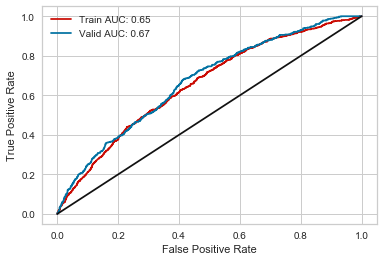

In [21]:
# Define X/Y Values
x_tr = x_tr_imb_sample
x_v = x_v
y_tr = y_tr_imb_sample
y_v = y_v

clf = BernoulliNB()
#clf = MultinomialNB()
#clf = ComplementNB()
#clf = GaussianNB()

train_model_default(clf, x_tr, x_v, y_tr, y_v)

#### Multinomial

         Score  Train Validation
0          AUC  0.658      0.665
1     Accuracy  0.618      0.579
2    Precision  0.614      0.086
3       Recall  0.634      0.650
4           F1  0.312      0.076
5  Specificity  0.602      0.574
6   Prevalence  0.500      0.058


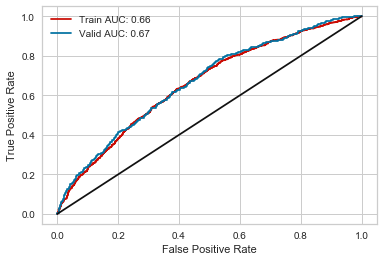

In [22]:
# Define X/Y Values
x_tr = x_tr_imb_sample
x_v = x_v
y_tr = y_tr_imb_sample
y_v = y_v

#clf = BernoulliNB()
clf = MultinomialNB()
#clf = ComplementNB()
#clf = GaussianNB()

train_model_default(clf, x_tr, x_v, y_tr, y_v)

#### Complement

         Score  Train Validation
0          AUC  0.658      0.665
1     Accuracy  0.618      0.579
2    Precision  0.614      0.086
3       Recall  0.634      0.650
4           F1  0.312      0.076
5  Specificity  0.602      0.574
6   Prevalence  0.500      0.058


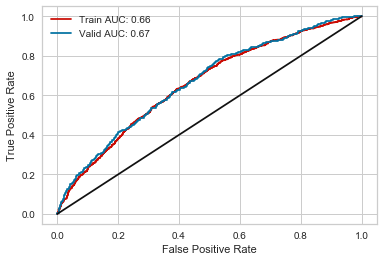

In [23]:
# Define X/Y Values
x_tr = x_tr_imb_sample
x_v = x_v
y_tr = y_tr_imb_sample
y_v = y_v

#clf = BernoulliNB()
#clf = MultinomialNB()
clf = ComplementNB()
#clf = GaussianNB()

train_model_default(clf, x_tr, x_v, y_tr, y_v)

#### Gaussian

         Score  Train Validation
0          AUC  0.651      0.662
1     Accuracy  0.569      0.284
2    Precision  0.543      0.070
3       Recall  0.882      0.917
4           F1  0.336      0.065
5  Specificity  0.256      0.245
6   Prevalence  0.500      0.058


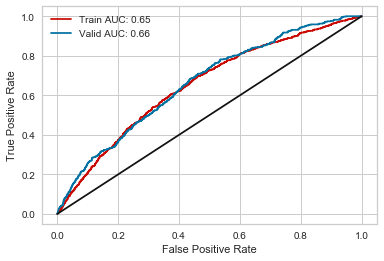

In [24]:
# Define X/Y Values
x_tr = x_tr_imb_sample
x_v = x_v
y_tr = y_tr_imb_sample
y_v = y_v

#clf = MultinomialNB()
#clf = ComplementNB()
clf = GaussianNB()
train_model_default(clf, x_tr, x_v, y_tr, y_v)

### Logistic Regression

         Score  Train Validation
0          AUC  0.669      0.665
1     Accuracy  0.626      0.588
2    Precision  0.624      0.087
3       Recall  0.636      0.640
4           F1  0.315      0.076
5  Specificity  0.616      0.585
6   Prevalence  0.500      0.058


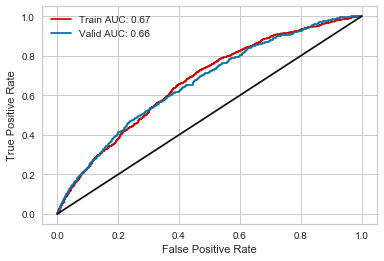

In [25]:
# Define Classifier - Default Settings
clf = LogisticRegression(random_state = random_state, solver = solver_log, max_iter = max_iter_log)

# Define X/Y Values
x_tr = x_tr_imb_sample
x_v = x_v
y_tr = y_tr_imb_sample
y_v = y_v

train_model_default(clf, x_tr, x_v, y_tr, y_v)

###  Random Forest

         Score  Train Validation
0          AUC  1.000      0.655
1     Accuracy  1.000      0.564
2    Precision  1.000      0.087
3       Recall  1.000      0.642
4           F1  0.500      0.077
5  Specificity  1.000      0.560
6   Prevalence  0.500      0.058


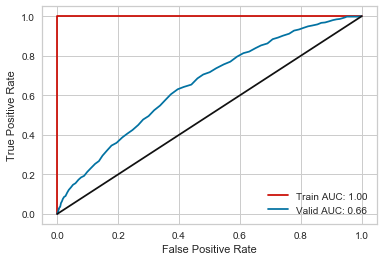

In [26]:
# Define Classifier - Default Settings
clf = RandomForestClassifier(random_state = random_state, n_estimators = 100)

# Define X/Y Values
x_tr = x_tr_imb_sample
x_v = x_v
y_tr = y_tr_imb_sample
y_v = y_v

train_model_default(clf, x_tr, x_v, y_tr, y_v)

### Gradient Boost Classifier

         Score  Train Validation
0          AUC  0.774      0.669
1     Accuracy  0.691      0.583
2    Precision  0.681      0.090
3       Recall  0.720      0.676
4           F1  0.350      0.079
5  Specificity  0.663      0.577
6   Prevalence  0.500      0.058


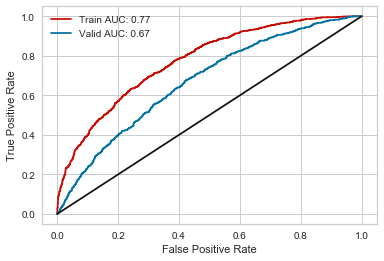

In [27]:
# Define Classifier - Default Settings
clf = GradientBoostingClassifier(random_state = random_state)

# Define X/Y Values
x_tr = x_tr_imb_sample
x_v = x_v
y_tr = y_tr_imb_sample
y_v = y_v

train_model_default(clf, x_tr, x_v, y_tr, y_v)

### Ada Boost Classifier

         Score  Train Validation
0          AUC  0.693      0.662
1     Accuracy  0.640      0.606
2    Precision  0.642      0.089
3       Recall  0.632      0.631
4           F1  0.318      0.078
5  Specificity  0.648      0.604
6   Prevalence  0.500      0.058


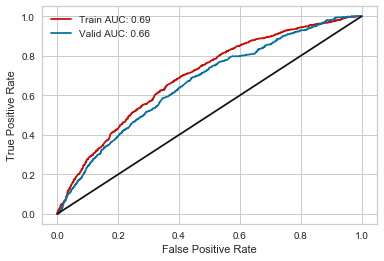

In [28]:
# Define Classifier - Default Settings
clf = AdaBoostClassifier(random_state = random_state)

# Define X/Y Values
x_tr = x_tr_imb_sample
x_v = x_v
y_tr = y_tr_imb_sample
y_v = y_v

train_model_default(clf, x_tr, x_v, y_tr, y_v)

### XGBoost

         Score  Train Validation
0          AUC  0.760      0.670
1     Accuracy  0.685      0.582
2    Precision  0.674      0.089
3       Recall  0.713      0.668
4           F1  0.347      0.078
5  Specificity  0.656      0.577
6   Prevalence  0.500      0.058


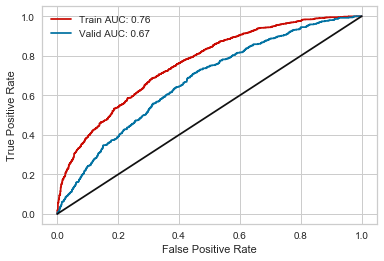

In [29]:
# Define Classifier - Default Settings
clf = XGBClassifier(random_state = random_state)

# Define X/Y Values
x_tr = x_tr_imb_sample
x_v = x_v
y_tr = y_tr_imb_sample
y_v = y_v

train_model_default(clf, x_tr, x_v, y_tr, y_v)

In [30]:
x_v.shape

(8775, 42)

In [31]:
x_tr.shape

(49818, 42)

In [32]:
y_tr.shape

(49818,)

In [33]:
y_v.shape

(8775,)

## Parameter Optimization

After analyzing a suite of classifiers using default setting, the following four classifiers returned quality results, so we will move forward with these models.

* Naive Bayes
* KNNeighbors
* XGBoost Classifier

#### Define X Y 

In [30]:
# Define X/Y Values
x_tr = x_tr_imb_sample
x_v = x_v
y_tr = y_tr_imb_sample
y_v = y_v

### Naive Bayes

Naive Bayes cannot use the dimensionally reduced matrices due to negative values.

#### Bernoulli

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  40 out of  55 | elapsed:    3.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    3.1s finished


Best parameters set found on training set:

{'alpha': 1.0}

0.603 (+/-0.019) for {'alpha': 1e-05}
0.603 (+/-0.019) for {'alpha': 0.0001}
0.603 (+/-0.019) for {'alpha': 0.001}
0.603 (+/-0.019) for {'alpha': 0.01}
0.603 (+/-0.019) for {'alpha': 0.1}
0.603 (+/-0.019) for {'alpha': 1.0}
0.600 (+/-0.019) for {'alpha': 10.0}
0.586 (+/-0.027) for {'alpha': 100.0}
0.556 (+/-0.050) for {'alpha': 1000.0}
0.543 (+/-0.036) for {'alpha': 10000.0}
0.540 (+/-0.036) for {'alpha': 100000.0}

         Score  Train Validation
0          AUC  0.654      0.669
1     Accuracy  0.608      0.553
2    Precision  0.599      0.088
3       Recall  0.658      0.713
4           F1  0.314      0.078
5  Specificity  0.559      0.543
6   Prevalence  0.500      0.058


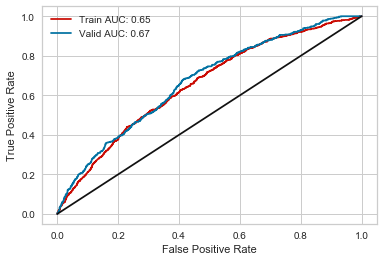

In [31]:
#Define Parameters
alpha = np.logspace(-5, 5, 11)

# Create hyperparameter options
hyperparameters = dict(alpha = alpha)

# Establish Classifier
clf = BernoulliNB()

clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_nb_ber_opt = clf

#### Gaussian

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.1s finished


Best parameters set found on training set:

{'var_smoothing': 1e-05}

0.521 (+/-0.054) for {'var_smoothing': 1e-09}
0.541 (+/-0.028) for {'var_smoothing': 1e-08}
0.562 (+/-0.021) for {'var_smoothing': 1e-07}
0.582 (+/-0.015) for {'var_smoothing': 1e-06}
0.599 (+/-0.012) for {'var_smoothing': 1e-05}
0.576 (+/-0.044) for {'var_smoothing': 0.0001}
0.561 (+/-0.043) for {'var_smoothing': 0.001}

         Score  Train Validation
0          AUC  0.659      0.669
1     Accuracy  0.617      0.468
2    Precision  0.591      0.080
3       Recall  0.758      0.778
4           F1  0.332      0.073
5  Specificity  0.475      0.449
6   Prevalence  0.500      0.058


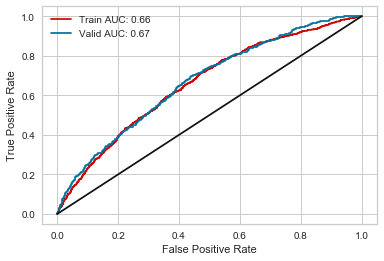

In [32]:
#Define Parameters
var_smoothing = np.logspace(-9, -3, 7)

#priors = np.linspace(.01, .99, 10).astype('float')

# Create hyperparameter options
hyperparameters = dict(var_smoothing = var_smoothing)

# Establish Classifier
clf = GaussianNB()

clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_nb_gaus_opt = clf

#### Complement

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished


Best parameters set found on training set:

{'alpha': 78.47599703514611, 'norm': 'True'}

0.464 (+/-0.098) for {'alpha': 1.0, 'norm': 'True'}
0.464 (+/-0.098) for {'alpha': 1.0, 'norm': 'False'}
0.471 (+/-0.098) for {'alpha': 1.6237767391887217, 'norm': 'True'}
0.471 (+/-0.098) for {'alpha': 1.6237767391887217, 'norm': 'False'}
0.482 (+/-0.081) for {'alpha': 2.636650898730358, 'norm': 'True'}
0.482 (+/-0.081) for {'alpha': 2.636650898730358, 'norm': 'False'}
0.491 (+/-0.080) for {'alpha': 4.281332398719393, 'norm': 'True'}
0.491 (+/-0.080) for {'alpha': 4.281332398719393, 'norm': 'False'}
0.500 (+/-0.071) for {'alpha': 6.951927961775605, 'norm': 'True'}
0.500 (+/-0.071) for {'alpha': 6.951927961775605, 'norm': 'False'}
0.514 (+/-0.057) for {'alpha': 11.28837891684689, 'norm': 'True'}
0.514 (+/-0.057) for {'alpha': 11.28837891684689, 'norm': 'False'}
0.522 (+/-0.050) for {'alpha': 18.329807108324356, 'norm': 'True'}
0.522 (+/-0.050) for {'alpha': 18.329807108324356, 'norm': 'False'}
0.5

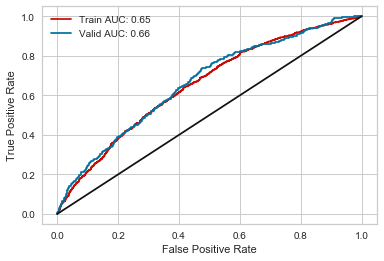

In [33]:
#Define Parameters
alpha = np.logspace(0, 4, 20)

norm = ['True', 'False']

# Create hyperparameter options
hyperparameters = dict(alpha = alpha, norm = norm)

# Establish Classifier
clf = ComplementNB()

clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_nb_comp_opt = clf

#### MultiNomial

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    0.1s finished


Best parameters set found on training set:

{'alpha': 1e-08}

0.606 (+/-0.025) for {'alpha': 1e-08}
0.606 (+/-0.025) for {'alpha': 1e-07}
0.606 (+/-0.025) for {'alpha': 1e-06}
0.606 (+/-0.025) for {'alpha': 1e-05}
0.606 (+/-0.025) for {'alpha': 0.0001}
0.606 (+/-0.025) for {'alpha': 0.001}
0.606 (+/-0.025) for {'alpha': 0.01}
0.606 (+/-0.025) for {'alpha': 0.1}
0.606 (+/-0.023) for {'alpha': 1.0}
0.604 (+/-0.022) for {'alpha': 10.0}
0.595 (+/-0.037) for {'alpha': 100.0}
0.439 (+/-0.082) for {'alpha': 1000.0}
0.334 (+/-0.003) for {'alpha': 10000.0}

         Score  Train Validation
0          AUC  0.659      0.666
1     Accuracy  0.617      0.580
2    Precision  0.614      0.086
3       Recall  0.633      0.652
4           F1  0.312      0.076
5  Specificity  0.602      0.575
6   Prevalence  0.500      0.058


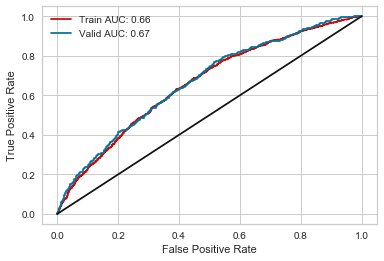

In [35]:
#Define Parameters
alpha = np.logspace(-8, 4, 13)

# Create hyperparameter options
hyperparameters = dict(alpha = alpha)

# Establish Classifier
clf = ComplementNB()

clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_nb_mn_opt = clf

### KNNeighbors

#### Define Function Inputs

In [36]:
# Establish Classifier
clf = KNeighborsClassifier()

#Define Parameters
n_neighbors  = np.linspace(2,12,6).astype('int') 
weights = ('uniform', 'distance')
metric = ('euclidean', 'manhattan')

# Create hyperparameter options
hyperparameters = dict(n_neighbors = n_neighbors, weights = weights, metric = metric)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.2s finished


Best parameters set found on training set:

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}

0.525 (+/-0.022) for {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
0.539 (+/-0.039) for {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
0.549 (+/-0.026) for {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
0.550 (+/-0.026) for {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
0.553 (+/-0.033) for {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'uniform'}
0.563 (+/-0.031) for {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
0.557 (+/-0.016) for {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'uniform'}
0.559 (+/-0.040) for {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}
0.558 (+/-0.018) for {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
0.560 (+/-0.025) for {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
0.554 (+/-0.010) for {'metric': 

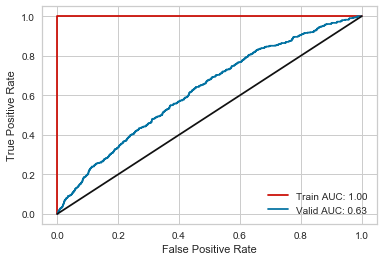

In [37]:
clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_knn_opt = clf

### Logistic Regression

#### Define Function Inputs

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.9min finished


Best parameters set found on training set:

{'C': 10.0, 'penalty': 'l2'}

0.333 (+/-0.000) for {'C': 0.001, 'penalty': 'l1'}
0.570 (+/-0.012) for {'C': 0.001, 'penalty': 'l2'}
0.497 (+/-0.164) for {'C': 0.01, 'penalty': 'l1'}
0.597 (+/-0.019) for {'C': 0.01, 'penalty': 'l2'}
0.600 (+/-0.028) for {'C': 0.1, 'penalty': 'l1'}
0.606 (+/-0.029) for {'C': 0.1, 'penalty': 'l2'}
0.606 (+/-0.036) for {'C': 1.0, 'penalty': 'l1'}
0.606 (+/-0.038) for {'C': 1.0, 'penalty': 'l2'}
0.607 (+/-0.037) for {'C': 10.0, 'penalty': 'l1'}
0.607 (+/-0.034) for {'C': 10.0, 'penalty': 'l2'}
0.607 (+/-0.035) for {'C': 100.0, 'penalty': 'l1'}
0.607 (+/-0.034) for {'C': 100.0, 'penalty': 'l2'}
0.607 (+/-0.034) for {'C': 1000.0, 'penalty': 'l1'}
0.607 (+/-0.034) for {'C': 1000.0, 'penalty': 'l2'}

         Score  Train Validation
0          AUC  0.669      0.665
1     Accuracy  0.626      0.589
2    Precision  0.624      0.087
3       Recall  0.636      0.642
4           F1  0.315      0.077
5  Specificity  0.617  

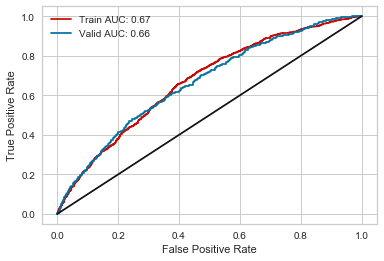

In [38]:
# Establish Classifier
clf = LogisticRegression(random_state = random_state, solver = solver_log, max_iter = max_iter_log)

#Define Parameters
penalty = ['l1','l2']       
C = np.logspace(-3, 3, 7)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty = penalty)

clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_log_opt = clf

### Random Forest

Random Forest models have so far performed so-so, and have taken a very long time to run. For the training data it often overfits to match 100%. I recommend commenting out these models until final analysis

#### Define Function Inputs

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 638 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 1138 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   37.3s finished


Best parameters set found on training set:

{'max_depth': 15, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 50}

0.614 (+/-0.013) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}
0.617 (+/-0.008) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.612 (+/-0.011) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.606 (+/-0.020) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 25}
0.609 (+/-0.018) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.608 (+/-0.008) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.612 (+/-0.027) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 25}
0.613 (+/-0.008) for {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
0.611 (+/-0.006) for {'ma

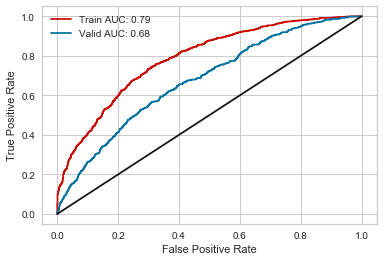

In [42]:
# Establish Classifier
clf = RandomForestClassifier(random_state = random_state)

#Define Parameters
n_estimators = [25, 50, 100]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 2, 5, 10] 


# Create hyperparameter options
hyperparameters = dict(n_estimators=n_estimators, 
                       max_depth=max_depth,
                       min_samples_split = min_samples_split,
                       min_samples_leaf = min_samples_leaf)

clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_rf_opt = clf

### Ada Boost

#### Define Function Inputs

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   32.6s finished


Best parameters set found on training set:

{'learning_rate': 0.1, 'n_estimators': 400}

0.490 (+/-0.086) for {'learning_rate': 0.001, 'n_estimators': 300}
0.513 (+/-0.075) for {'learning_rate': 0.001, 'n_estimators': 400}
0.535 (+/-0.067) for {'learning_rate': 0.001, 'n_estimators': 500}
0.548 (+/-0.069) for {'learning_rate': 0.001, 'n_estimators': 600}
0.586 (+/-0.032) for {'learning_rate': 0.01, 'n_estimators': 300}
0.587 (+/-0.037) for {'learning_rate': 0.01, 'n_estimators': 400}
0.591 (+/-0.025) for {'learning_rate': 0.01, 'n_estimators': 500}
0.594 (+/-0.022) for {'learning_rate': 0.01, 'n_estimators': 600}
0.612 (+/-0.016) for {'learning_rate': 0.1, 'n_estimators': 300}
0.612 (+/-0.021) for {'learning_rate': 0.1, 'n_estimators': 400}
0.609 (+/-0.015) for {'learning_rate': 0.1, 'n_estimators': 500}
0.608 (+/-0.015) for {'learning_rate': 0.1, 'n_estimators': 600}
0.589 (+/-0.030) for {'learning_rate': 1.0, 'n_estimators': 300}
0.588 (+/-0.031) for {'learning_rate': 1.0, 'n_estimat

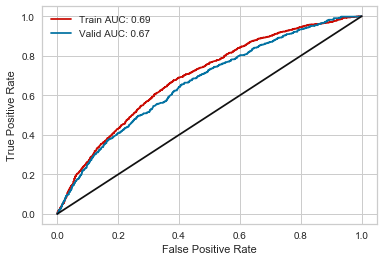

In [44]:
# Establish Classifier
clf = AdaBoostClassifier(random_state = random_state)

#Define Parameters
n_estimators = [300, 400, 500, 600]
learning_rate = np.logspace(-3, 1, 5)

# Create hyperparameter options
hyperparameters = dict(n_estimators=n_estimators, 
                       learning_rate=learning_rate)

clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_ada_opt = clf

### XGBoost

#### Define Function Inputs

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.0s finished


Best parameters set found on training set:

{'learning_rate': 0.1, 'n_estimators': 100}

0.541 (+/-0.038) for {'learning_rate': 0.0001, 'n_estimators': 25}
0.547 (+/-0.026) for {'learning_rate': 0.0001, 'n_estimators': 50}
0.547 (+/-0.026) for {'learning_rate': 0.0001, 'n_estimators': 100}
0.549 (+/-0.026) for {'learning_rate': 0.0001, 'n_estimators': 150}
0.551 (+/-0.028) for {'learning_rate': 0.0001, 'n_estimators': 200}
0.554 (+/-0.025) for {'learning_rate': 0.001, 'n_estimators': 25}
0.554 (+/-0.024) for {'learning_rate': 0.001, 'n_estimators': 50}
0.553 (+/-0.025) for {'learning_rate': 0.001, 'n_estimators': 100}
0.553 (+/-0.024) for {'learning_rate': 0.001, 'n_estimators': 150}
0.550 (+/-0.023) for {'learning_rate': 0.001, 'n_estimators': 200}
0.554 (+/-0.031) for {'learning_rate': 0.01, 'n_estimators': 25}
0.566 (+/-0.026) for {'learning_rate': 0.01, 'n_estimators': 50}
0.593 (+/-0.012) for {'learning_rate': 0.01, 'n_estimators': 100}
0.592 (+/-0.025) for {'learning_rate': 0.01,

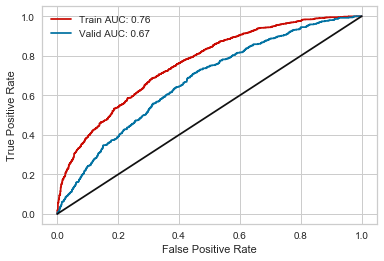

In [57]:
# Establish Classifier
clf = XGBClassifier(random_state = random_state)

#Define Parameters
n_estimators = [25, 50, 100, 150, 200]
learning_rate = np.logspace(-4, 1, 6)

# Create hyperparameter options
hyperparameters = dict(n_estimators=n_estimators, learning_rate=learning_rate)

clf = grid_search_opt(x_tr, x_v, y_tr, y_v, clf, hyperparameters)

opt_model_scoring(clf, x_tr, x_v, y_tr, y_v)

# Define for Test Analysis
clf_xbg_opt = clf

# Test Set Scoring

## General Function

In [46]:
def test_score (clf, x):
    
    print("Detailed classification report:")
    print()
    print("The model is trained and tuned on the training and validation sets..")
    print("The scores are computed on the test set.")
    print()
    y_true, y_pred = y_te, clf.predict(x)
    print(classification_report(y_true, y_pred, digits = 3))
    print()
    
    prevalence_te = '%.3f' %calc_prevalence(y_true)
    auc_score_te = '%.3f' %roc_auc_score(y_true, y_pred)
    print('AUC Score: ', auc_score_te)
    print('Positive Target Prevalence: ', prevalence_te)
    

In [47]:
def test_score_cv(clf, x):
    scoring = ['roc_auc', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
    
    results = cross_validate(estimator = clf,
                                          X = x,
                                          y = y_te,
                                          cv = 5,
                                          scoring = scoring)
    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        print('%s : %.3f' % (metric_name, average_score))
    
    prevalence_te = '%.3f' %calc_prevalence(y_te)
    print('positive target prevalence: ', prevalence_te)

## Naive Bayes

### Overall Metrics

In [48]:
test_score(clf_nb_ber_opt, x_te)

Detailed classification report:

The model is trained and tuned on the training and validation sets..
The scores are computed on the test set.

              precision    recall  f1-score   support

           0      0.960     0.548     0.698      8241
           1      0.085     0.652     0.151       534

    accuracy                          0.554      8775
   macro avg      0.523     0.600     0.424      8775
weighted avg      0.907     0.554     0.664      8775


AUC Score:  0.600
Positive Target Prevalence:  0.061


### Cross Validation

In [49]:
test_score_cv(clf_nb_ber_opt, x_te)

fit_time : 0.010
score_time : 0.019
test_roc_auc : 0.633
test_accuracy : 0.938
test_balanced_accuracy : 0.502
test_precision : 0.130
test_recall : 0.006
test_f1 : 0.011
positive target prevalence:  0.061


C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## KNNeighbors

### Overall Metrics

In [50]:
test_score(clf_knn_opt, x_te)

Detailed classification report:

The model is trained and tuned on the training and validation sets..
The scores are computed on the test set.

              precision    recall  f1-score   support

           0      0.957     0.513     0.668      8241
           1      0.079     0.644     0.141       534

    accuracy                          0.521      8775
   macro avg      0.518     0.579     0.404      8775
weighted avg      0.904     0.521     0.636      8775


AUC Score:  0.579
Positive Target Prevalence:  0.061


### Cross Validation

In [51]:
test_score_cv(clf_knn_opt, x_te)

C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fit_time : 0.018
score_time : 0.881
test_roc_auc : 0.522
test_accuracy : 0.938
test_balanced_accuracy : 0.501
test_precision : 0.167
test_recall : 0.004
test_f1 : 0.007
positive target prevalence:  0.061


## Logistic Regression

### Overall Metrics

In [52]:
test_score(clf_log_opt, x_te)

Detailed classification report:

The model is trained and tuned on the training and validation sets..
The scores are computed on the test set.

              precision    recall  f1-score   support

           0      0.960     0.593     0.733      8241
           1      0.090     0.622     0.157       534

    accuracy                          0.594      8775
   macro avg      0.525     0.607     0.445      8775
weighted avg      0.907     0.594     0.698      8775


AUC Score:  0.607
Positive Target Prevalence:  0.061


### Cross Validation

In [53]:
test_score_cv(clf_log_opt, x_te)

C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarni

fit_time : 13.751
score_time : 0.012
test_roc_auc : 0.632
test_accuracy : 0.939
test_balanced_accuracy : 0.500
test_precision : 0.000
test_recall : 0.000
test_f1 : 0.000
positive target prevalence:  0.061


C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Random Forest

In [ ]:
clf = clf_rf_opt

In [62]:
test_score(clf, x_te)

Detailed classification report:

The model is trained and tuned on the training and validation sets..
The scores are computed on the test set.

              precision    recall  f1-score   support

           0      0.958     0.569     0.714      8241
           1      0.085     0.616     0.149       534

    accuracy                          0.572      8775
   macro avg      0.522     0.593     0.432      8775
weighted avg      0.905     0.572     0.680      8775


AUC Score:  0.593
Positive Target Prevalence:  0.061


In [63]:
test_score_cv(clf, x_te)

C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undef

fit_time : 0.573
score_time : 0.038
test_roc_auc : 0.637
test_accuracy : 0.939
test_balanced_accuracy : 0.500
test_precision : 0.000
test_recall : 0.000
test_f1 : 0.000
positive target prevalence:  0.061


C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Ada Boost

In [54]:
clf = clf_ada_opt

### Overall Metrics

In [55]:
test_score(clf, x_te)

Detailed classification report:

The model is trained and tuned on the training and validation sets..
The scores are computed on the test set.

              precision    recall  f1-score   support

           0      0.959     0.595     0.734      8241
           1      0.088     0.603     0.154       534

    accuracy                          0.595      8775
   macro avg      0.523     0.599     0.444      8775
weighted avg      0.906     0.595     0.699      8775


AUC Score:  0.599
Positive Target Prevalence:  0.061


### Cross Validation

In [56]:
test_score_cv(clf, x_te)

C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undef

fit_time : 2.709
score_time : 0.907
test_roc_auc : 0.636
test_accuracy : 0.939
test_balanced_accuracy : 0.500
test_precision : 0.000
test_recall : 0.000
test_f1 : 0.000
positive target prevalence:  0.061


C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## XGBoost

In [58]:
clf = clf_xbg_opt

### Overall Metrics

In [59]:
test_score(clf, x_te)

Detailed classification report:

The model is trained and tuned on the training and validation sets..
The scores are computed on the test set.

              precision    recall  f1-score   support

           0      0.958     0.569     0.714      8241
           1      0.085     0.616     0.149       534

    accuracy                          0.572      8775
   macro avg      0.522     0.593     0.432      8775
weighted avg      0.905     0.572     0.680      8775


AUC Score:  0.593
Positive Target Prevalence:  0.061


### Cross Validation

In [61]:
test_score_cv(clf, x_te)

C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undef

fit_time : 0.595
score_time : 0.038
test_roc_auc : 0.637
test_accuracy : 0.939
test_balanced_accuracy : 0.500
test_precision : 0.000
test_recall : 0.000
test_f1 : 0.000
positive target prevalence:  0.061


C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\canfi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Visuals

## ROC

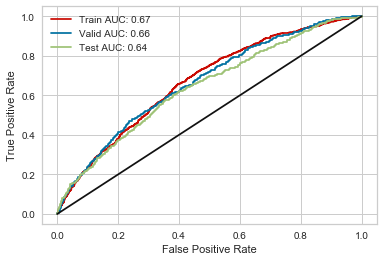

In [66]:
# Define X/Y Values
x_tr = x_tr_imb_sample
x_v = x_v
x_te = x_te
y_tr = y_tr_imb_sample
y_v = y_v
y_te = y_te


model = clf_log_opt

y_train_preds = model.predict_proba(x_tr)[:,1]
y_valid_preds = model.predict_proba(x_v)[:,1]
y_test_preds = model.predict_proba(x_te)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_tr, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_v, y_valid_preds)
fpr_test, tpr_test, thresholds_test = roc_curve(y_te, y_test_preds)

thresh = 0.5

auc_train = roc_auc_score(y_tr, y_train_preds)
auc_valid = roc_auc_score(y_v, y_valid_preds)
auc_test = roc_auc_score(y_te, y_test_preds)

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot(fpr_test, tpr_test,'g-',label = 'Test AUC: %.2f'%auc_test)

plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()